In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import timm

from torchvision.models.efficientnet import EfficientNet_B0_Weights
from torchvision.transforms import Compose, ToTensor

In [ ]:
path = kagglehub.dataset_download("danisactive/processed-plant-disease")

print("Path to dataset files:", path)

100%|██████████| 1.34G/1.34G [00:19<00:00, 73.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danisactive/processed-plant-disease/versions/1


In [ ]:
from pathlib import Path
import json

# Create a Path object for the dataset directory
dataset_path = Path(path)

print("Dataset Directory Contents:")
for item in dataset_path.iterdir():
    print(item.name)

# Construct the full path to the class_names.json file
class_names_file = dataset_path / "class_names.json"

# Open and load the class_names.json file
with open(class_names_file, "r") as f:
    class_names = json.load(f)

print("\nLoaded Class Names:")
print(class_names)
print(f"Number of classes: {len(class_names)}")

Dataset Directory Contents:
class_names.json
processed
class_names.csv

Loaded Class Names:
{'0': 'Apple___Apple_scab', '1': 'Apple___Black_rot', '2': 'Apple___Cedar_apple_rust', '3': 'Apple___healthy', '4': 'Blueberry___healthy', '5': 'Cherry_(including_sour)___Powdery_mildew', '6': 'Cherry_(including_sour)___healthy', '7': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', '8': 'Corn_(maize)___Common_rust_', '9': 'Corn_(maize)___Northern_Leaf_Blight', '10': 'Corn_(maize)___healthy', '11': 'Grape___Black_rot', '12': 'Grape___Esca_(Black_Measles)', '13': 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', '14': 'Grape___healthy', '15': 'Orange___Haunglongbing_(Citrus_greening)', '16': 'Peach___Bacterial_spot', '17': 'Peach___healthy', '18': 'Pepper,_bell___Bacterial_spot', '19': 'Pepper,_bell___healthy', '20': 'Potato___Early_blight', '21': 'Potato___Late_blight', '22': 'Potato___healthy', '23': 'Raspberry___healthy', '24': 'Soybean___healthy', '25': 'Squash___Powdery_mildew', '26': 'Stra

In [ ]:
data = {
    "train": dataset_path /"processed" / "processed" / "train",
    "test": dataset_path / "processed" / "test"
}

train_data = data["train"]
data

{'train': PosixPath('/root/.cache/kagglehub/datasets/danisactive/processed-plant-disease/versions/1/processed/processed/train'),
 'test': PosixPath('/root/.cache/kagglehub/datasets/danisactive/processed-plant-disease/versions/1/processed/test')}

In [ ]:
from torchvision import transforms

# ImageNet statistics for normalization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Define training transformations
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Define validation/testing transformations
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print("Image transformations for training and validation defined successfully.")

Image transformations for training and validation defined successfully.


In [ ]:
from torchvision.datasets import ImageFolder
# Define batch size
batch_size = 32

train_dataset = ImageFolder(root=data["train"], transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Number of training samples: {len(train_dataset)}")
# print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")
# print(f"Number of test batches: {len(test_dataloader)}")

# Verify
for images, labels in train_dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Number of training samples: 70320
Number of training batches: 2198
Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


In [ ]:
classes = []
for i, class_name in class_names.items():
    classes.append(class_name)
    print(i, class_name)

0 Apple___Apple_scab
1 Apple___Black_rot
2 Apple___Cedar_apple_rust
3 Apple___healthy
4 Blueberry___healthy
5 Cherry_(including_sour)___Powdery_mildew
6 Cherry_(including_sour)___healthy
7 Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
8 Corn_(maize)___Common_rust_
9 Corn_(maize)___Northern_Leaf_Blight
10 Corn_(maize)___healthy
11 Grape___Black_rot
12 Grape___Esca_(Black_Measles)
13 Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14 Grape___healthy
15 Orange___Haunglongbing_(Citrus_greening)
16 Peach___Bacterial_spot
17 Peach___healthy
18 Pepper,_bell___Bacterial_spot
19 Pepper,_bell___healthy
20 Potato___Early_blight
21 Potato___Late_blight
22 Potato___healthy
23 Raspberry___healthy
24 Soybean___healthy
25 Squash___Powdery_mildew
26 Strawberry___Leaf_scorch
27 Strawberry___healthy
28 Tomato___Bacterial_spot
29 Tomato___Early_blight
30 Tomato___Late_blight
31 Tomato___Leaf_Mold
32 Tomato___Septoria_leaf_spot
33 Tomato___Spider_mites Two-spotted_spider_mite
34 Tomato___Target_Spot
35 Tom

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# ResNet-18
# 'DEFAULT' loads the best available weights
resnet = torch.hub.load('pytorch/vision', 'resnet18', weights='DEFAULT')
# EfficientNet-B0
effnet = torch.hub.load('pytorch/vision', 'efficientnet_b0', weights='DEFAULT')

resnet.eval()
effnet.eval()

print("Models loaded successfully!")

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]

Models loaded successfully!


In [ ]:
# HyperParameters
seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-3

## ResNet Experiment

In [ ]:
resnet.requires_grad_(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
n_features = resnet.fc.in_features
n_features

512

In [ ]:
resnet.fc = nn.Linear(n_features, len(classes))

In [ ]:
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Trainable: fc.weight
Trainable: fc.bias


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet.fc.parameters(), lr=lr)
optimizer_resnet, loss_fn

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 CrossEntropyLoss())

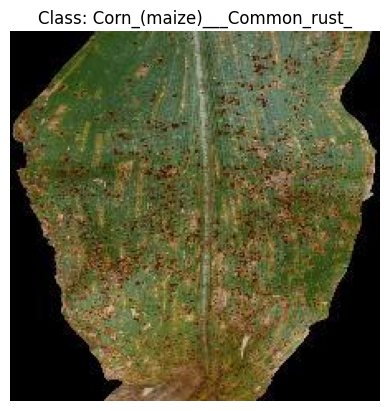

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get a random index
random_idx = random.randint(0, len(train_dataset) - 1)

# Get the image and label
image, label = train_dataset[random_idx]

# Denormalize the image for display
# Convert to numpy array and transpose from (C, H, W) to (H, W, C)
image_np = image.numpy().transpose((1, 2, 0))

# Reverse normalization
mean = np.array(MEAN)
std = np.array(STD)
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

class_name = classes[label]

plt.imshow(image_np)
plt.title(f"Class: {class_name}")
plt.axis("off")
plt.show()

### This is the new "head" training (for the model to adapt to the numbe of dataset classes)

In [ ]:
num_epochs = 3
resnet.to(device)
resnet.train()

# running_loss_count = []
# correct_predictions_count = []
# total_samples_count = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        # running_loss_count.append(running_loss)
        # correct_predictions_count.append(correct_predictions)
        # total_samples_count.append(total_samples)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
    print("😟 Done")

Epoch 1/3 | Loss: 0.5117 | Acc: 0.8812
😟 Done
Epoch 2/3 | Loss: 0.2091 | Acc: 0.9380
😟 Done
Epoch 3/3 | Loss: 0.1745 | Acc: 0.9450
😟 Done


In [ ]:
import os

os.makedirs("checkpoints", exist_ok=True)
stage1_path = "checkpoints/resnet_stage1_feature_extraction.pth"
# model's state_dict
torch.save(resnet.state_dict(), stage1_path)

print(f"Stage 1(Head training) model saved to: {stage1_path}")

Stage 1(Head training) model saved to: checkpoints/resnet_stage1_feature_extraction.pth


In [ ]:
resnet.requires_grad_(True)

num_epochs = 5

resnet.to(device)
resnet.train()


history = {
    'epoch_loss': [],
    'epoch_acc': []
}

batch_loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        batch_loss_history.append(loss.item())

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples).cpu().item()

    history['epoch_loss'].append(epoch_loss)
    history['epoch_acc'].append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
    print("😟 Done")

Epoch 1/5 | Loss: 0.1583 | Acc: 0.9495
😟 Done
Epoch 2/5 | Loss: 0.1454 | Acc: 0.9525
😟 Done
Epoch 3/5 | Loss: 0.1391 | Acc: 0.9539
😟 Done
Epoch 4/5 | Loss: 0.1317 | Acc: 0.9572
😟 Done
Epoch 5/5 | Loss: 0.1289 | Acc: 0.9569
😟 Done


In [ ]:
os.makedirs("checkpoints", exist_ok=True)
stage2_path = "checkpoints/resnet_stage2_finetuning.pth"
# model's state_dict
torch.save(resnet.state_dict(), stage2_path)

print(f"Stage 2(Finetuning) model saved to: {stage2_path}")

Stage 2(Finetuning) model saved to: checkpoints/resnet_stage2_finetuning.pth


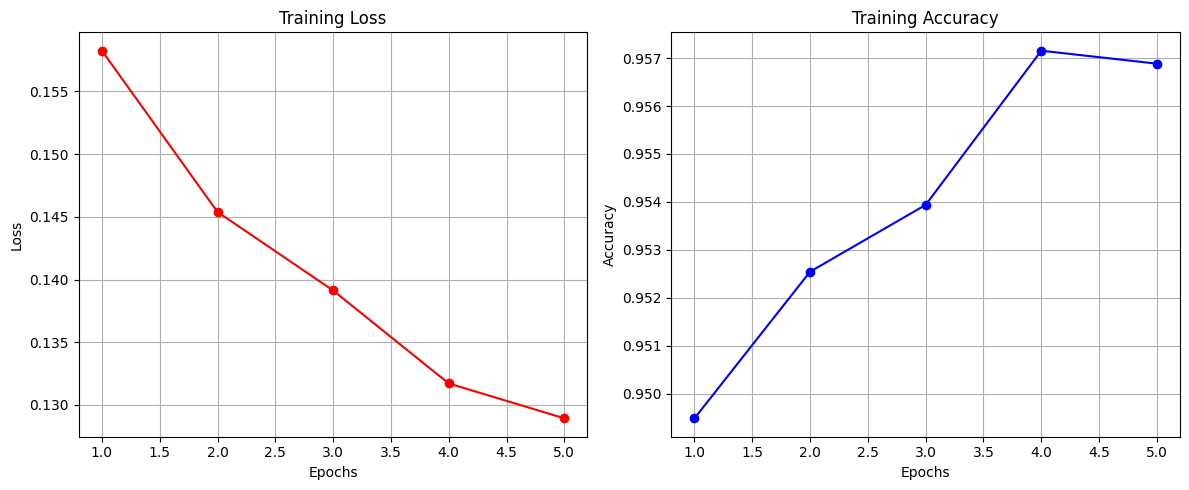

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot 1: Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history['epoch_loss'], marker='o', label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plot 2: Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history['epoch_acc'], marker='o', label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

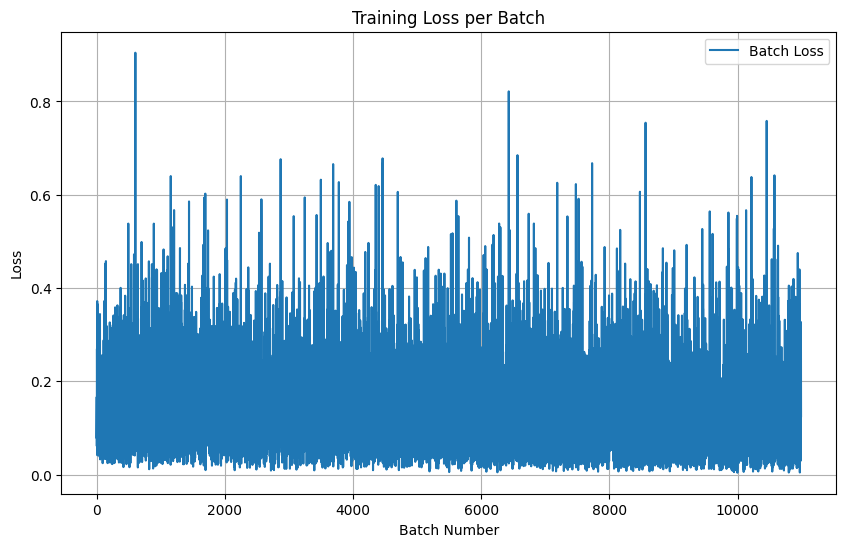

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(batch_loss_history, label='Batch Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import torch.nn.functional as F
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_map = None
        self.gradients = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def _save_feature_map(module, input, output):
            self.feature_map = output

        def _save_gradients(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.hooks.append(self.target_layer.register_forward_hook(_save_feature_map))
        self.hooks.append(self.target_layer.register_backward_hook(_save_gradients))

    def __call__(self, input_image, target_class=None):
        self.model.eval()
        logits = self.model(input_image)

        if target_class is None:
            target_class = logits.argmax(dim=1)

        self.model.zero_grad()

        # Calculate gradients of the predicted class score with respect to the output
        one_hot = torch.zeros_like(logits).to(input_image.device)
        for i in range(input_image.shape[0]):
            one_hot[i, target_class[i]] = 1.0

        logits.backward(gradient=one_hot, retain_graph=True)

        # Retrieve stored feature map and gradients
        feature_map = self.feature_map
        gradients = self.gradients

        # Global average pooling of gradients to get neuron importance weights
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        # Multiply the feature map by the importance weights and sum across channel dimension
        cam = weights * feature_map
        cam = torch.sum(cam, dim=1, keepdim=True)

        # Apply ReLU activation
        cam = F.relu(cam)

        # Resize the heatmap to the original input image size
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        # Normalize the heatmap to a range between 0 and 1
        cam_min, cam_max = cam.min(), cam.max()
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        return cam.squeeze().detach().cpu().numpy()

    def __del__(self):
        # Remove hooks to prevent memory leaks
        for hook in self.hooks:
            hook.remove()

def show_cam_on_image(img_np, heatmap_np):
    # Ensure image is in 0-255 range and BGR for cv2
    img_np = (img_np * 255).astype(np.uint8)
    if img_np.shape[2] == 3: # Convert RGB to BGR if needed
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # Resize heatmap to match image dimensions
    heatmap_np = cv2.resize(heatmap_np, (img_np.shape[1], img_np.shape[0]))
    heatmap_np = np.uint8(255 * heatmap_np)
    heatmap = cv2.applyColorMap(heatmap_np, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    # Alpha blend: output = alpha * image + (1 - alpha) * heatmap
    alpha = 0.5
    superimposed_img = cv2.addWeighted(img_np, alpha, heatmap, 1 - alpha, 0)

    return superimposed_img

print("GradCAM class and show_cam_on_image function defined successfully.")

GradCAM class and show_cam_on_image function defined successfully.


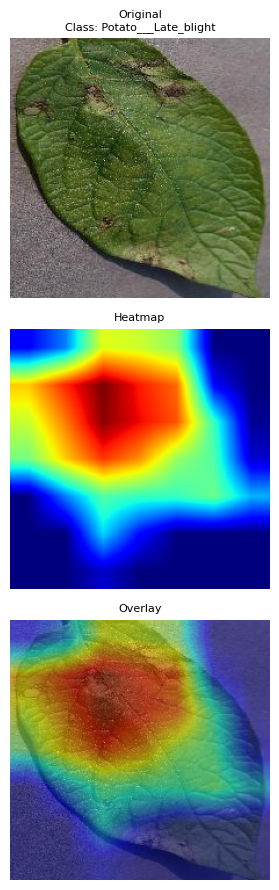

Displayed Grad-CAM visualizations for 1 random images.


In [ ]:
import matplotlib.pyplot as plt

target_layer = resnet.layer4[-1] # Typically the last convolutional layer before pooling
gradcam = GradCAM(resnet, target_layer)

resnet.eval()
resnet.to(device)

num_samples = 1
plt.figure(figsize=(num_samples * 3, 9))

for i in range(num_samples):
    # random image and label
    random_idx = random.randint(0, len(train_dataset) - 1)
    original_image_tensor, label = train_dataset[random_idx]
    class_name = classes[label]

    input_image_batch = original_image_tensor.unsqueeze(0).to(device) # Add batch dimension

    # Generate heatmap
    heatmap = gradcam(input_image_batch, target_class=torch.tensor([label]).to(device))

    # Denormalize the original image for display
    img_for_display = original_image_tensor.numpy().transpose((1, 2, 0))
    mean = np.array(MEAN)
    std = np.array(STD)
    img_for_display = std * img_for_display + mean
    img_for_display = np.clip(img_for_display, 0, 1)

    # Overlay heatmap on image
    superimposed_img = show_cam_on_image(img_for_display, heatmap)

    # Plotting
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(img_for_display)
    plt.title(f"Original\nClass: {class_name}", fontsize=8)
    plt.axis('off')

    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Heatmap", fontsize=8)
    plt.axis('off')

    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    # Convert BGR (from cv2) back to RGB for matplotlib
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Displayed Grad-CAM visualizations for {num_samples} random images.")


### GradCAM note
*   The `GradCAM` class and helper function `show_cam_on_image`. The `GradCAM` class is designed to generate attention maps using forward and backward hooks, and the `show_cam_on_image` function overlays heatmaps onto original images.
*   Grad-CAM attention maps were successfully generated for x randomly selected images from the `train_dataset` using a pre-trained `resnet` model, targeting the `resnet.layer4[-1]` layer. yup yup
*   For each of the x selected images, the original image, the generated heatmap, and the overlaid result (original image with heatmap).



## Effeceint-Net_b0 Experiment

### Functions that are necessary to avoid waste of time

In [ ]:
def set_classifier_head(model, num_classes):
    """Dynamically sets the classifier head of a given model."""
    # Determine the type of model and replace its final layer
    if hasattr(model, 'fc'): # ResNet, AlexNet, VGG
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential): # EfficientNet, DenseNet
        if isinstance(model.classifier[-1], nn.Linear):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        elif hasattr(model.classifier, 'in_features'): # Specific case for EfficientNet-like classifier structure
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'): # Some custom models
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Model's final classification layer not found or not supported.")

    print(f"Classifier head set to {num_classes} classes.")
    return model

def freeze_model_weights(model):
    """Freezes all parameters in the model except the final classification layer."""
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the final classification layer (which was just replaced or modified)
    if hasattr(model, 'fc'):
        for param in model.fc.parameters():
            param.requires_grad = True
    elif hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
        for param in model.classifier[-1].parameters():
            param.requires_grad = True
    elif hasattr(model, 'head'):
        for param in model.head.parameters():
            param.requires_grad = True
    else:
        print("Warning: Could not identify classification head to unfreeze. Ensure it's handled correctly.")

    print("Model base layers frozen, classifier head unfrozen.")

def unfreeze_model_weights(model):
    """Unfreezes all parameters in the model."""
    for param in model.parameters():
        param.requires_grad = True
    print("All model layers unfrozen.")

def train_loop(model, dataloader, loss_fn, optimizer, num_epochs, device):
    """Generic training loop for feature extraction and fine-tuning."""
    model.to(device)
    model.train() # Set model to training mode

    effnet_history = {'epoch_loss': [], 'epoch_acc': []}
    effnet_batch_loss_history = []

    for epoch in range(num_epochs):
        effnet_running_loss = 0.0
        effnet_correct_predictions = 0
        effnet_total_samples = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            effnet_batch_loss_history.append(loss.item())

            effnet_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            effnet_correct_predictions += torch.sum(preds == labels.data)
            effnet_total_samples += labels.size(0)

        effnet_epoch_loss = effnet_running_loss / effnet_total_samples
        effnet_epoch_acc = (effnet_correct_predictions.double() / effnet_total_samples).cpu().item()

        effnet_history['epoch_loss'].append(effnet_epoch_loss)
        effnet_history['epoch_acc'].append(effnet_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {effnet_epoch_loss:.4f} | Acc: {effnet_epoch_acc:.4f}")

    print("Training complete.")
    return effnet_history, effnet_batch_loss_history

print("Model setup and training functions defined successfully.")

Model setup and training functions defined successfully.


### EfficientNet-B0 Feature Extraction (Head Training)

In [ ]:

num_classes = len(classes)
effnet = set_classifier_head(effnet, num_classes)

freeze_model_weights(effnet)

optimizer_effnet = torch.optim.Adam(effnet.parameters(), lr=lr)

print("\nStarting EfficientNet-B0 head training...")
history_effnet_stage1, batch_loss_effnet_stage1 = train_loop(
    effnet, train_dataloader, loss_fn, optimizer_effnet, num_epochs=3, device=device
)

os.makedirs("checkpoints", exist_ok=True)
stage1_effnet_path = "checkpoints/efficientnet_stage1_feature_extraction.pth"
torch.save(effnet.state_dict(), stage1_effnet_path)

print(f"EfficientNet-B0 Stage 1 (Head training) model saved to: {stage1_effnet_path}")

Classifier head set to 39 classes.
Model base layers frozen, classifier head unfrozen.

Starting EfficientNet-B0 head training...
Epoch 1/3 | Loss: 0.4869 | Acc: 0.8914
Epoch 2/3 | Loss: 0.2114 | Acc: 0.9382
Epoch 3/3 | Loss: 0.1776 | Acc: 0.9465
Training complete.
EfficientNet-B0 Stage 1 (Head training) model saved to: checkpoints/efficientnet_stage1_feature_extraction.pth


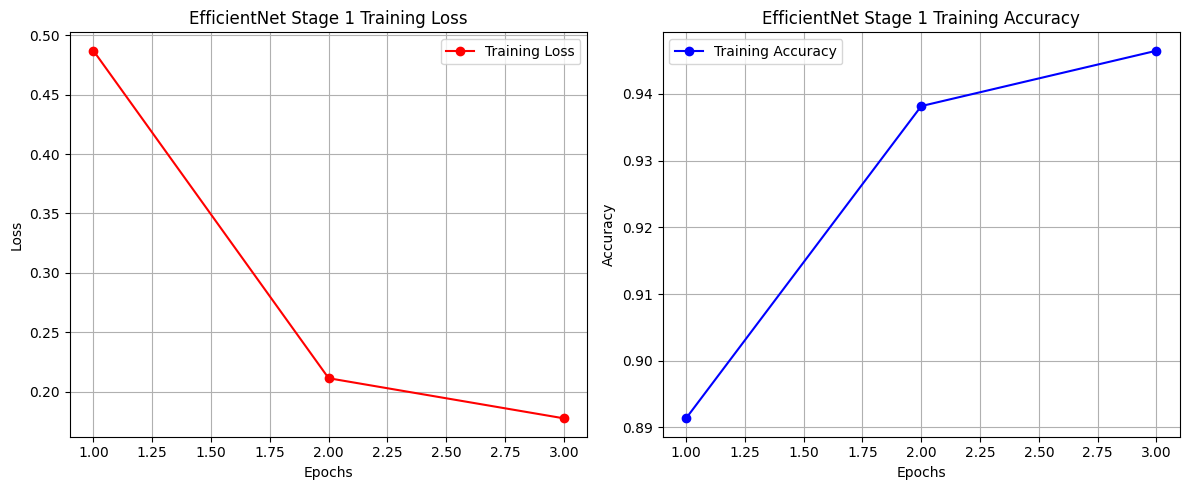

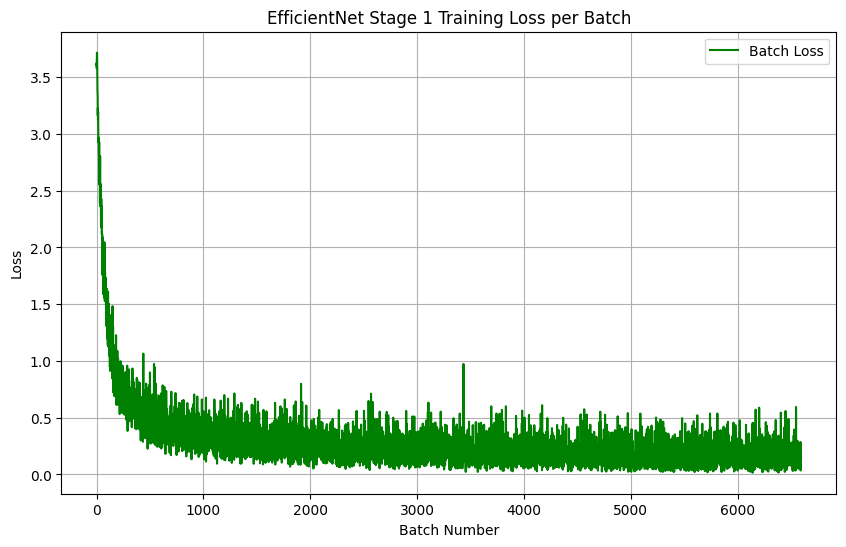

EfficientNet-B0 Stage 1 training history plots displayed.


In [44]:
import matplotlib.pyplot as plt

# Get the number of epochs from history_effnet_stage1
num_epochs_effnet_stage1 = len(history_effnet_stage1['epoch_loss'])

# Create a figure with two subplots for epoch-wise loss and accuracy
plt.figure(figsize=(12, 5))

# Plot 1: Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_effnet_stage1 + 1), history_effnet_stage1['epoch_loss'], marker='o', label='Training Loss', color='red')
plt.title('EfficientNet Stage 1 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot 2: Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_effnet_stage1 + 1), history_effnet_stage1['epoch_acc'], marker='o', label='Training Accuracy', color='blue')
plt.title('EfficientNet Stage 1 Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Create a separate figure for batch-wise loss
plt.figure(figsize=(10, 6))
plt.plot(batch_loss_effnet_stage1, label='Batch Loss', color='green')
plt.title('EfficientNet Stage 1 Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

print("EfficientNet-B0 Stage 1 training history plots displayed.")

Generating Grad-CAM visualizations for 3 random images from EfficientNet-B0...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


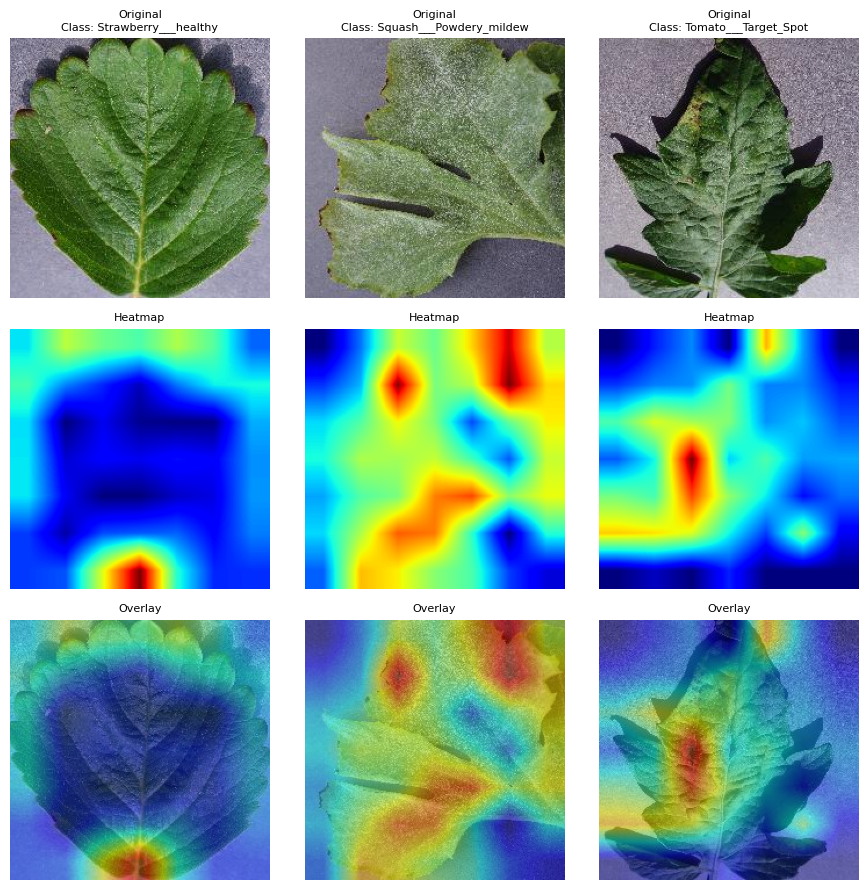

Displayed Grad-CAM visualizations for 3 random images using EfficientNet-B0.


In [45]:
target_layer_effnet = effnet.features[-1] # The last convolutional layer in EfficientNet
gradcam_effnet = GradCAM(effnet, target_layer_effnet)

effnet.eval()
effnet.to(device)

num_samples = 3
plt.figure(figsize=(num_samples * 3, 9))

print(f"Generating Grad-CAM visualizations for {num_samples} random images from EfficientNet-B0...")

for i in range(num_samples):
    # random image and label
    random_idx = random.randint(0, len(train_dataset) - 1)
    original_image_tensor, label = train_dataset[random_idx]
    class_name = classes[label]

    input_image_batch = original_image_tensor.unsqueeze(0).to(device) # Add batch dimension

    # Generate heatmap
    heatmap = gradcam_effnet(input_image_batch, target_class=torch.tensor([label]).to(device))

    # Denormalize the original image for display
    img_for_display = original_image_tensor.numpy().transpose((1, 2, 0))
    mean = np.array(MEAN)
    std = np.array(STD)
    img_for_display = std * img_for_display + mean
    img_for_display = np.clip(img_for_display, 0, 1)

    # Overlay heatmap on image
    superimposed_img = show_cam_on_image(img_for_display, heatmap)

    # Plotting
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(img_for_display)
    plt.title(f"Original\nClass: {class_name}", fontsize=8)
    plt.axis('off')

    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Heatmap", fontsize=8)
    plt.axis('off')

    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    # Convert BGR (from cv2) back to RGB for matplotlib
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Displayed Grad-CAM visualizations for {num_samples} random images using EfficientNet-B0.")